## Sentiment Analysis

In [1]:
from groq import Groq
import os
import datetime
import pandas as pd
import numpy as np
import sys
import re
import csv

In [2]:
chunk_size = 1000
chunks = []
target_stocks = ['AAPL', 'AMZN', 'AVGO', 'BRK','GOGL','LLY','MSFT','NVDA','TSLA','XOM']
c = 0
sum_before = 0

In [7]:

for chunk in pd.read_csv(r'C:\Users\buste\Downloads\nasdaq.csv', chunksize=chunk_size):
    chunk['index_column'] = pd.to_numeric(chunk.iloc[:, 0], errors='coerce')
    chunk = chunk.dropna(subset=['index_column']) 
    bf = len(chunk)
    sum_before += bf
    chunk['index_column'] = chunk['index_column'].astype(int)
    chunk = chunk[chunk['Stock_symbol'].isin(target_stocks)]
    af = len(chunk)
    chunks.append(chunk)
    c += 1
    if c <100: # diagnostics
        print('Chunk number', c, 'Before: ', bf, 'After: ', af)


df = pd.concat(chunks, ignore_index=True)
print("Loading dataset complete. Before filtering for target stocks there were ", sum_before, " rows. After filtering for target stocks there are ", len(df), " rows.")
print("Writing to csv file")
df.to_csv(r'C:\Users\buste\Downloads\nasdaq_filtered.csv', index=False)
print("Writing to csv file complete")

Chunk number 1 Before:  1000 After:  0
Chunk number 2 Before:  1000 After:  0
Chunk number 3 Before:  1000 After:  0
Chunk number 4 Before:  1000 After:  0
Chunk number 5 Before:  1000 After:  0
Chunk number 6 Before:  1000 After:  0
Chunk number 7 Before:  1000 After:  0
Chunk number 8 Before:  1000 After:  0
Chunk number 9 Before:  1000 After:  0
Chunk number 10 Before:  1000 After:  0
Chunk number 11 Before:  1000 After:  0
Chunk number 12 Before:  1000 After:  0
Chunk number 13 Before:  1000 After:  975
Chunk number 14 Before:  1000 After:  1000
Chunk number 15 Before:  1000 After:  1000
Chunk number 16 Before:  1000 After:  1000
Chunk number 17 Before:  1000 After:  1000
Chunk number 18 Before:  1000 After:  1000
Chunk number 19 Before:  1000 After:  1000
Chunk number 20 Before:  1000 After:  1000
Chunk number 21 Before:  1000 After:  890
Chunk number 22 Before:  1000 After:  0
Chunk number 23 Before:  1000 After:  0
Chunk number 24 Before:  1000 After:  0
Chunk number 25 Before: 

In [8]:
unique_values = df['Stock_symbol'].unique()
np.savetxt(r'C:\Users\buste\Downloads\unique_values.txt', unique_values, fmt='%s')

In [9]:
most_recent_date = df['Date'].max()
print(most_recent_date)
oldest_date = df['Date'].min()
print(oldest_date)

2023-12-16 23:02:00 UTC
2009-10-19 00:00:00 UTC


In [10]:
print(df['Stock_symbol'].unique())

['AAPL' 'AMZN' 'AVGO' 'BRK' 'GOGL' 'LLY' 'MSFT' 'NVDA' 'TSLA' 'XOM']


In [11]:
print("Before removing data not in date range, we had ", len(df), " rows.")
df = df[(df['Date'] >= '2018-12-01') & (df['Date'] <= '2023-12-01')]
print("After removing data not in date range, we have ", len(df), " rows.")

Before removing data not in date range, we had  55639  rows.
After removing data not in date range, we have  52524  rows.


In [23]:
df = df[['Date', 'Stock_symbol', 'Article_title','index_column']]
df.to_csv(r'C:\Users\buste\Downloads\nasdaq_preprocessed.csv', index=False)
print("Writing to csv file complete")

Writing to csv file complete


In [23]:
df = pd.read_csv(r'C:\Users\buste\Downloads\nasdaq_preprocessed.csv')

df.columns

Index(['index_column', 'Date', 'Stock_symbol', 'Article_title'], dtype='object')

In [41]:
df['Article_title'] = df['Article_title'].str.replace('"', '')
df['formatted'] = df['index_column'].astype(str) + '|' + df['Date'].astype(str) + '|' + df['Stock_symbol'] + '|' + df['Article_title']

df['formatted'] = df['formatted'].astype(str)

df['formatted'].to_csv(
    r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt',
    sep='|',            
    index=False,
    header=False,
    quoting=csv.QUOTE_NONE,  
    escapechar='\\'      
)

## LLM Annotations

In [3]:
with open(r"C:\Users\buste\Downloads\nasdaq_preprocessed.txt", 'r') as sample_file:
    sam = sample_file.read()

# index_column, date and stock_symbol have a "\" at the end of the string. This is removed by the following code.
sam = re.sub(r'\\', '', sam)

# save as txt file 
with open(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', 'w') as f:
    f.write(sam)

In [3]:
def read_file_and_chunk(file_path, chunk_size=350):
    """Reads the file and chunks the lines."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [lines[i:i + chunk_size] for i in range(0, len(lines), chunk_size)]

def send_request(data_chunk):
    """Sends a request to the Groq API."""
    formatted_lines = ''.join(data_chunk)
    completion = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "user",
                "content": f"Please score the sentiment of each title from stock-related news articles based on the impact on its stock symbol. Use the scale: very positive (2), positive (1), neutral (0), negative (-1), and very negative (-2). Here are the formatted lines:\n{formatted_lines}\nProduce results in this strict format without adding any extra content or characters: index_column|date|stock_symbol|sentiment_score. Ensure accuracy in steps by copying the exact index_column."
            },
        ],
        temperature=1,  # Controlling randomness.
        top_p=1,  # Controlling nucleus sampling.
        stream=False  # Batch process mode.
    )
    return completion

In [5]:
client = Groq(api_key='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')

def read_file_and_chunk(file_path, chunk_size=350):
    """Reads the file and chunks the lines."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [lines[i:i + chunk_size] for i in range(0, len(lines), chunk_size)]

def send_request(data_chunk):
    """Sends a request to the Groq API."""
    formatted_lines = ''.join(data_chunk)
    completion = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "user",
                "content": f"Please score the sentiment of each title from stock-related news articles based on the impact on its stock symbol. Use the scale: very positive (2), positive (1), neutral (0), negative (-1), and very negative (-2). Here are the formatted lines:\n{formatted_lines}\nProduce results in this strict format without adding any extra content or characters: index_column|date|stock_symbol|sentiment_score. Ensure accuracy in steps by copying the exact index_column."
            },
        ],
        temperature=1,  # Controlling randomness.
        top_p=1,  # Controlling nucleus sampling.
        stream=False  # Batch process mode.
    )
    return completion

file_path = r"C:\Users\buste\Downloads\nasdaq_preprocessed.txt"

chunks = read_file_and_chunk(file_path)

# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'results_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in results_file_{c}.txt")

Chunk 0 processed and stored in results_file_0.txt
Chunk 1 processed and stored in results_file_1.txt
Chunk 2 processed and stored in results_file_2.txt
Chunk 3 processed and stored in results_file_3.txt
Chunk 4 processed and stored in results_file_4.txt
Chunk 5 processed and stored in results_file_5.txt
Chunk 6 processed and stored in results_file_6.txt
Chunk 7 processed and stored in results_file_7.txt
Chunk 8 processed and stored in results_file_8.txt
Chunk 9 processed and stored in results_file_9.txt
Chunk 10 processed and stored in results_file_10.txt
Chunk 11 processed and stored in results_file_11.txt
Chunk 12 processed and stored in results_file_12.txt
Chunk 13 processed and stored in results_file_13.txt
Chunk 14 processed and stored in results_file_14.txt
Chunk 15 processed and stored in results_file_15.txt
Chunk 16 processed and stored in results_file_16.txt
Chunk 17 processed and stored in results_file_17.txt
Chunk 18 processed and stored in results_file_18.txt
Chunk 19 proc

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j3gk96ywekvtdgczy913597q` on : Limit 1000000, Used 1003999, Requested 8971. Please try again in 18m40.6394s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

In [7]:
# Process each chunk and store results.
for c, chunk in enumerate(chunks[46:]):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'results_file_{c+46}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c+46} processed and stored in results_file_{c+46}.txt")

Chunk 46 processed and stored in results_file_46.txt
Chunk 47 processed and stored in results_file_47.txt
Chunk 48 processed and stored in results_file_48.txt
Chunk 49 processed and stored in results_file_49.txt
Chunk 50 processed and stored in results_file_50.txt
Chunk 51 processed and stored in results_file_51.txt
Chunk 52 processed and stored in results_file_52.txt
Chunk 53 processed and stored in results_file_53.txt
Chunk 54 processed and stored in results_file_54.txt
Chunk 55 processed and stored in results_file_55.txt
Chunk 56 processed and stored in results_file_56.txt
Chunk 57 processed and stored in results_file_57.txt
Chunk 58 processed and stored in results_file_58.txt
Chunk 59 processed and stored in results_file_59.txt
Chunk 60 processed and stored in results_file_60.txt
Chunk 61 processed and stored in results_file_61.txt
Chunk 62 processed and stored in results_file_62.txt
Chunk 63 processed and stored in results_file_63.txt
Chunk 64 processed and stored in results_file_

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j3gk96ywekvtdgczy913597q` on : Limit 1000000, Used 992796, Requested 8349. Please try again in 1m38.890799999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

In [10]:
# Process each chunk and store results.
for c, chunk in enumerate(chunks[105:]):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'results_file_{c+105}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c+105} processed and stored in results_file_{c+105}.txt")

Chunk 105 processed and stored in results_file_105.txt
Chunk 106 processed and stored in results_file_106.txt
Chunk 107 processed and stored in results_file_107.txt
Chunk 108 processed and stored in results_file_108.txt
Chunk 109 processed and stored in results_file_109.txt
Chunk 110 processed and stored in results_file_110.txt
Chunk 111 processed and stored in results_file_111.txt
Chunk 112 processed and stored in results_file_112.txt
Chunk 113 processed and stored in results_file_113.txt
Chunk 114 processed and stored in results_file_114.txt
Chunk 115 processed and stored in results_file_115.txt
Chunk 116 processed and stored in results_file_116.txt
Chunk 117 processed and stored in results_file_117.txt
Chunk 118 processed and stored in results_file_118.txt
Chunk 119 processed and stored in results_file_119.txt
Chunk 120 processed and stored in results_file_120.txt
Chunk 121 processed and stored in results_file_121.txt
Chunk 122 processed and stored in results_file_122.txt
Chunk 123 

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j3gk96ywekvtdgczy913597q` on : Limit 1000000, Used 1010220, Requested 708. Please try again in 15m44.2586s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

### Data post-processing
This step was done to check which article titles recieved a score. This was done because there were a lot of articles passed through that did not get analysed for sentiment successfully. So all unprocessed titles indexes were obtained to draft a new document to annotate for sentiment yet again.

In [58]:
# Step 1: Compile results from individual files into one file
with open('compiled_results.txt', 'w') as outfile:
    for i in range(150):
        try:
            with open(f'results_file_{i}.txt') as infile:
                outfile.write(infile.read())
        except FileNotFoundError:
            print(f"File results_file_{i}.txt not found.")
            continue  # Skip files that aren't found

# Step 2: Read the compiled results and filter lines
compiled_results = []
with open('compiled_results.txt', 'r') as file:
    compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
print("length of results_df after filtering out invalid entries: ", len(results_df))

# Check all values in index_column are integers
if results_df['index_column'].dtype != np.int64:
    print("index_column has non-integer values.")
    sys.exit(1)

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('cleaned_results_v1.csv', index=False)

length of results_df before filtering out invalid entries:  45879
length of results_df after filtering out invalid entries:  31548


### Filtering unprocessed data to be filtered.

In [10]:
def filter_txt_file(file, results_df, new_file='filtered_file.txt'):
    '''Find the index numbers in the file and create a new file with all lines that have an index that is not in the results_df['index_column']'''
    with open(file, 'r', encoding='utf-8') as f:  # Specify utf-8 encoding
        lines = f.readlines()
    with open(new_file, 'w', encoding='utf-8') as f:  # Also specify utf-8 for output file to maintain consistency
        for line in lines:
            index = int(line.split('|')[0])
            if index not in results_df['index_column'].values:
                f.write(line)



In [57]:


filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', results_df, new_file='filtered_file.txt')

# Check that the filtered file has the correct number of lines
with open('filtered_file.txt', 'r') as f:
    lines = f.readlines()
print("Number of lines in filtered_file.txt: ", len(lines))

Number of lines in filtered_file.txt:  21563


In [21]:
# compile all the results_file_{c}.txt files into one file
with open('compiled_results.txt', 'w') as outfile:
    for i in range(150):
        with open(f'results_file_{i}.txt') as infile:
            outfile.write(infile.read())

# read the compiled_results.txt file that i want transformed into a dataframe
with open('compiled_results.txt', 'r') as file:
    compiled_results = file.readlines()

# read the nasdaq_preprocessed.txt file
with open(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', 'r') as file:
    nasdaq_preprocessed = file.readlines()

# convert both to dataframes for comparison, import only lines that start with an index number and also parse it so that the sep = | and the columns are named index_column, date, stock_symbol, sentiment_score
print(len(compiled_results))
compiled_results = [line for line in compiled_results if line[0].isdigit()]
print(len(compiled_results))
compiled_results_df = pd.DataFrame(compiled_results)
compiled_results_df.head()


46042
45910


,0
0,12323|2023-11-30 00:00:00 UTC|AAPL|0\n
1,12324|2023-11-30 00:00:00 UTC|AAPL|0\n
2,12325|2023-11-30 00:00:00 UTC|AAPL|0\n
3,12326|2023-11-30 00:00:00 UTC|AAPL|0\n
4,12327|2023-11-30 00:00:00 UTC|AAPL|0\n


In [ ]:
# Step 3: Convert compiled results into a DataFrame
compiled_results_df = pd.DataFrame([x.split('|') for x in compiled_results], columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])
compiled_results_df['sentiment_score'] = compiled_results_df['sentiment_score'].str.strip()  # Clean up whitespace

# Step 4: Read the NASDAQ preprocessed data
nasdaq_preprocessed = []
with open(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', 'r') as file:
    nasdaq_preprocessed = [line.strip() for line in file if line[0].isdigit()]

# Step 5: Convert NASDAQ data into a DataFrame
nasdaq_preprocessed_df = pd.DataFrame([x.split('|') for x in nasdaq_preprocessed], columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])
nasdaq_preprocessed_df['sentiment_score'] = nasdaq_preprocessed_df['sentiment_score'].str.strip()  # Clean up whitespace

# Display the first few rows of each DataFrame to check
print(compiled_results_df.head())
print(nasdaq_preprocessed_df.head())

In [24]:
compiled_results_df
compiled_results_df.columns = ['index_column', 'date', 'stock_symbol', 'sentiment_score', 'null', 'null2', 'null3']
compiled_results_df = compiled_results_df.drop(columns=['null', 'null2', 'null3'])
# remove the \n from the sentiment_score column
compiled_results_df['sentiment_score'] = compiled_results_df['sentiment_score'].str.replace('\n', '')

KeyError: '0'

In [15]:
print(compiled_results)

['12323|2023-11-30 00:00:00 UTC|AAPL|0\n', '12324|2023-11-30 00:00:00 UTC|AAPL|0\n', '12325|2023-11-30 00:00:00 UTC|AAPL|0\n', '12326|2023-11-30 00:00:00 UTC|AAPL|0\n', '12327|2023-11-30 00:00:00 UTC|AAPL|0\n', '12328|2023-11-30 00:00:00 UTC|AAPL|2\n', '12329|2023-11-30 00:00:00 UTC|AAPL|0\n', '12330|2023-11-30 00:00:00 UTC|AAPL|0\n', '12331|2023-11-30 00:00:00 UTC|AAPL|0\n', '12332|2023-11-30 00:00:00 UTC|AAPL|2\n', '12333|2023-11-30 00:00:00 UTC|AAPL|2\n', '12334|2023-11-30 00:00:00 UTC|AAPL|2\n', '12335|2023-11-29 00:00:00 UTC|AAPL|2\n', '12336|2023-11-29 00:00:00 UTC|AAPL|-1\n', '12337|2023-11-29 00:00:00 UTC|AAPL|-1\n', '12338|2023-11-29 00:00:00 UTC|AAPL|0\n', '12339|2023-11-29 00:00:00 UTC|AAPL|1\n', '12340|2023-11-29 00:00:00 UTC|AAPL|0\n', '12341|2023-11-29 00:00:00 UTC|AAPL|0\n', '12342|2023-11-29 00:00:00 UTC|AAPL|0\n', '12343|2023-11-29 00:00:00 UTC|AAPL|1\n', '12344|2023-11-29 00:00:00 UTC|AAPL|0\n', '12345|2023-11-29 00:00:00 UTC|AAPL|0\n', '12346|2023-11-29 00:00:00 UTC|

In [42]:
compiled_results_df.head()


,index_column,date,stock_symbol,sentiment_score
0,203348,2023-06-09,AMZN,1
1,203349,2023-06-09,AMZN,0
2,203350,2023-06-09,AMZN,-1
3,203351,2023-06-09,AMZN,0
4,203352,2023-06-09,AMZN,0


In [43]:
nasdaq_preprocessed_df = pd.DataFrame(nasdaq_preprocessed, columns=['nasdaq_preprocessed'])
nasdaq_preprocessed_df = nasdaq_preprocessed_df['nasdaq_preprocessed'].str.split('|', expand=True)
nasdaq_preprocessed_df.columns = ['index_column', 'date', 'stock_symbol', 'article_title','null']
nasdaq_preprocessed_df = nasdaq_preprocessed_df.drop(columns=['null'])
nasdaq_preprocessed_df = nasdaq_preprocessed_df[nasdaq_preprocessed_df['index_column'].str.isnumeric()] 

In [45]:
# print lines that dont have an integer in the index_column
compiled_results_df = compiled_results_df[compiled_results_df['index_column'].str.isnumeric()]


In [48]:
nasdaq_preprocessed_df['index_column'] = nasdaq_preprocessed_df['index_column'].astype(int)
compiled_results_df['index_column'] = compiled_results_df['index_column'].astype(int)
len(compiled_results_df)

10949

In [49]:
# merge the two dataframes on the index_column
nasdaq_preprocessed_df = nasdaq_preprocessed_df[:11900]
merged_df = pd.merge(nasdaq_preprocessed_df, compiled_results_df, on='index_column', how='left')

# check if there are any null values in the sentiment_score column
null_values = merged_df[merged_df['sentiment_score'].isnull()]
len(null_values)

1932

## Sentiment Analysis for the remaining lines

In [4]:
def new_read_file_and_chunk(file_path, chunk_size=100):
    """Reads the file with UTF-8 encoding and chunks the lines."""
    with open(file_path, 'r', encoding='utf-8') as file:  # Specify UTF-8 encoding here
        lines = file.readlines()
    return [lines[i:i + chunk_size] for i in range(0, len(lines), chunk_size)]

In [9]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\filtered_file.txt"
chunks = new_read_file_and_chunk(file_path)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'second_results_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in second_results_file_{c}.txt")

Chunk 0 processed and stored in second_results_file_0.txt
Chunk 1 processed and stored in second_results_file_1.txt
Chunk 2 processed and stored in second_results_file_2.txt
Chunk 3 processed and stored in second_results_file_3.txt
Chunk 4 processed and stored in second_results_file_4.txt
Chunk 5 processed and stored in second_results_file_5.txt
Chunk 6 processed and stored in second_results_file_6.txt
Chunk 7 processed and stored in second_results_file_7.txt
Chunk 8 processed and stored in second_results_file_8.txt
Chunk 9 processed and stored in second_results_file_9.txt
Chunk 10 processed and stored in second_results_file_10.txt
Chunk 11 processed and stored in second_results_file_11.txt
Chunk 12 processed and stored in second_results_file_12.txt
Chunk 13 processed and stored in second_results_file_13.txt
Chunk 14 processed and stored in second_results_file_14.txt
Chunk 15 processed and stored in second_results_file_15.txt
Chunk 16 processed and stored in second_results_file_16.txt


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j3gk96ywekvtdgczy913597q` on : Limit 1000000, Used 999343, Requested 2639. Please try again in 2m51.1904s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

In [11]:
# compile all the results_file_{c}.txt files into one file
with open('second_compiled_results.txt', 'w') as outfile:
    for i in range(170):
        # write a new line after each file
        outfile.write('\n')
        with open(f'second_results_file_{i}.txt') as infile:
            outfile.write(infile.read())

In [18]:
# Step 2: Read the compiled results and filter lines
second_compiled_results = []
with open('second_compiled_results.txt', 'r') as file:
    second_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in second_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('second_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  17551
length of results_df after filtering out invalid entries:  2524


,index_column,date,stock_symbol,sentiment_score
0,12672,2023-11-06,AAPL,-1
1,12673,2023-11-06,AAPL,2
2,13022,2023-10-20,AAPL,1
3,13023,2023-10-20,AAPL,0
4,13372,2023-09-29,AAPL,0


In [21]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df after removing duplicates:  34072


In [29]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='second_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('second_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in second_filtered_file.txt: ", len(lines))

Number of lines in second_filtered_file.txt:  19039


### Third time obtaining sentiment score for remaining titles with no annotation
Given the total initial length of 52524 articles, and the processed amount of lines, 34072, we have 19039 articles left. There is some overlap however we will process this once all the articles have been given a score.

In [5]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\second_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'third_results_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in third_results_file_{c}.txt")

Chunk 0 processed and stored in third_results_file_0.txt
Chunk 1 processed and stored in third_results_file_1.txt
Chunk 2 processed and stored in third_results_file_2.txt
Chunk 3 processed and stored in third_results_file_3.txt
Chunk 4 processed and stored in third_results_file_4.txt
Chunk 5 processed and stored in third_results_file_5.txt
Chunk 6 processed and stored in third_results_file_6.txt
Chunk 7 processed and stored in third_results_file_7.txt
Chunk 8 processed and stored in third_results_file_8.txt
Chunk 9 processed and stored in third_results_file_9.txt
Chunk 10 processed and stored in third_results_file_10.txt
Chunk 11 processed and stored in third_results_file_11.txt
Chunk 12 processed and stored in third_results_file_12.txt
Chunk 13 processed and stored in third_results_file_13.txt
Chunk 14 processed and stored in third_results_file_14.txt
Chunk 15 processed and stored in third_results_file_15.txt
Chunk 16 processed and stored in third_results_file_16.txt
Chunk 17 processe

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j3gk96ywekvtdgczy913597q` on : Limit 1000000, Used 994447, Requested 9095. Please try again in 5m6.0052s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}

In [6]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\second_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks[50:]):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'third_results_file_{c+50}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c+50} processed and stored in third_results_file_{c+50}.txt")

Chunk 50 processed and stored in third_results_file_50.txt
Chunk 51 processed and stored in third_results_file_51.txt
Chunk 52 processed and stored in third_results_file_52.txt
Chunk 53 processed and stored in third_results_file_53.txt
Chunk 54 processed and stored in third_results_file_54.txt


In [7]:
# compile all the results_file_{c}.txt files into one file
with open('third_compiled_results.txt', 'w') as outfile:
    for i in range(55):
        # write a new line after each file
        outfile.write('\n')
        with open(f'third_results_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
third_compiled_results = []
with open('third_compiled_results.txt', 'r') as file:
    third_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in third_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('third_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  16646
length of results_df after filtering out invalid entries:  3517


In [8]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df after removing duplicates:  37582


In [ ]:
# compile all the results_file_{c}.txt files into one file
with open('third_compiled_results.txt', 'w') as outfile:
    for i in range(55):
        # write a new line after each file
        outfile.write('\n')
        with open(f'third_results_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
third_compiled_results = []
with open('third_compiled_results.txt', 'r') as file:
    third_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in third_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('third_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  16646
length of results_df after filtering out invalid entries:  3517


In [ ]:
# compile all the results_file_{c}.txt files into one file
with open('third_compiled_results.txt', 'w') as outfile:
    for i in range(55):
        # write a new line after each file
        outfile.write('\n')
        with open(f'third_results_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
third_compiled_results = []
with open('third_compiled_results.txt', 'r') as file:
    third_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in third_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('third_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  16646
length of results_df after filtering out invalid entries:  3517


In [ ]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df after removing duplicates:  37582


In [ ]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='third_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('third_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in third_filtered_file.txt: ", len(lines))

Number of lines in third_filtered_file.txt:  15529


In [ ]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df after removing duplicates:  37582


In [ ]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='third_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('third_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in third_filtered_file.txt: ", len(lines))

Number of lines in third_filtered_file.txt:  15529


### Annoating a fourth time

In [13]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\third_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'fourth_results_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in fourth_results_file_{c}.txt")

Chunk 0 processed and stored in fourth_results_file_0.txt
Chunk 1 processed and stored in fourth_results_file_1.txt
Chunk 2 processed and stored in fourth_results_file_2.txt
Chunk 3 processed and stored in fourth_results_file_3.txt
Chunk 4 processed and stored in fourth_results_file_4.txt
Chunk 5 processed and stored in fourth_results_file_5.txt


APITimeoutError: Request timed out.

In [14]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\third_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks[6:]):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'fourth_results_file_{c+6}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c+6} processed and stored in fourth_results_file_{c+6}.txt")

Chunk 6 processed and stored in fourth_results_file_6.txt
Chunk 7 processed and stored in fourth_results_file_7.txt
Chunk 8 processed and stored in fourth_results_file_8.txt
Chunk 9 processed and stored in fourth_results_file_9.txt
Chunk 10 processed and stored in fourth_results_file_10.txt
Chunk 11 processed and stored in fourth_results_file_11.txt
Chunk 12 processed and stored in fourth_results_file_12.txt
Chunk 13 processed and stored in fourth_results_file_13.txt
Chunk 14 processed and stored in fourth_results_file_14.txt
Chunk 15 processed and stored in fourth_results_file_15.txt
Chunk 16 processed and stored in fourth_results_file_16.txt
Chunk 17 processed and stored in fourth_results_file_17.txt
Chunk 18 processed and stored in fourth_results_file_18.txt
Chunk 19 processed and stored in fourth_results_file_19.txt
Chunk 20 processed and stored in fourth_results_file_20.txt
Chunk 21 processed and stored in fourth_results_file_21.txt
Chunk 22 processed and stored in fourth_results_

In [16]:
# compile all the results_file_{c}.txt files into one file
with open('fourth_compiled_results.txt', 'w') as outfile:
    for i in range(45):
        # write a new line after each file
        outfile.write('\n')
        with open(f'fourth_results_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
fourth_compiled_results = []
with open('fourth_compiled_results.txt', 'r') as file:
    fourth_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in fourth_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('fourth_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  12793
length of results_df after filtering out invalid entries:  8916


In [17]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df after removing duplicates:  46019


In [18]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='fourth_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('fourth_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in fourth_filtered_file.txt: ", len(lines))

Number of lines in fourth_filtered_file.txt:  7093


In [19]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\fourth_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'fifth_results_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in fifth_results_file_{c}.txt")

Chunk 0 processed and stored in fifth_results_file_0.txt
Chunk 1 processed and stored in fifth_results_file_1.txt
Chunk 2 processed and stored in fifth_results_file_2.txt
Chunk 3 processed and stored in fifth_results_file_3.txt
Chunk 4 processed and stored in fifth_results_file_4.txt
Chunk 5 processed and stored in fifth_results_file_5.txt
Chunk 6 processed and stored in fifth_results_file_6.txt
Chunk 7 processed and stored in fifth_results_file_7.txt
Chunk 8 processed and stored in fifth_results_file_8.txt
Chunk 9 processed and stored in fifth_results_file_9.txt
Chunk 10 processed and stored in fifth_results_file_10.txt
Chunk 11 processed and stored in fifth_results_file_11.txt
Chunk 12 processed and stored in fifth_results_file_12.txt
Chunk 13 processed and stored in fifth_results_file_13.txt
Chunk 14 processed and stored in fifth_results_file_14.txt
Chunk 15 processed and stored in fifth_results_file_15.txt
Chunk 16 processed and stored in fifth_results_file_16.txt
Chunk 17 processe

In [21]:
# compile all the results_file_{c}.txt files into one file
with open('fifth_compiled_results.txt', 'w') as outfile:
    for i in range(21):
        # write a new line after each file
        outfile.write('\n')
        with open(f'fifth_results_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
fifth_compiled_results = []
with open('fifth_compiled_results.txt', 'r') as file:
    fifth_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in fifth_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('fifth_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  6223
length of results_df after filtering out invalid entries:  2450


In [22]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
temp_results_df_5 = pd.read_csv('fifth_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
print("length of temp_results_df_5: ", len(temp_results_df_5))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4,temp_results_df_5]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df_5:  2450
length of temp_results_df after removing duplicates:  48440


In [23]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='fifth_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('fifth_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in fifth_filtered_file.txt: ", len(lines))

Number of lines in fifth_filtered_file.txt:  4672


In [24]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\fifth_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'sixth_results_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in sixth_results_file_{c}.txt")

Chunk 0 processed and stored in sixth_results_file_0.txt
Chunk 1 processed and stored in sixth_results_file_1.txt
Chunk 2 processed and stored in sixth_results_file_2.txt
Chunk 3 processed and stored in sixth_results_file_3.txt
Chunk 4 processed and stored in sixth_results_file_4.txt
Chunk 5 processed and stored in sixth_results_file_5.txt
Chunk 6 processed and stored in sixth_results_file_6.txt
Chunk 7 processed and stored in sixth_results_file_7.txt
Chunk 8 processed and stored in sixth_results_file_8.txt
Chunk 9 processed and stored in sixth_results_file_9.txt
Chunk 10 processed and stored in sixth_results_file_10.txt
Chunk 11 processed and stored in sixth_results_file_11.txt
Chunk 12 processed and stored in sixth_results_file_12.txt
Chunk 13 processed and stored in sixth_results_file_13.txt


In [29]:
# compile all the results_file_{c}.txt files into one file
with open('sixth_compiled_results.txt', 'w') as outfile:
    for i in range(14):
        # write a new line after each file
        outfile.write('\n')
        with open(f'sixth_results_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
sixth_compiled_results = []
with open('sixth_compiled_results.txt', 'r') as file:
    sixth_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in sixth_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('sixth_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  3634
length of results_df after filtering out invalid entries:  1257


In [30]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
temp_results_df_5 = pd.read_csv('fifth_cleaned_results_v1.csv')
temp_results_df_6 = pd.read_csv('sixth_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
print("length of temp_results_df_5: ", len(temp_results_df_5))
print("length of temp_results_df_6: ", len(temp_results_df_6))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4,temp_results_df_5,temp_results_df_6]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df_5:  2450
length of temp_results_df_6:  1257
length of temp_results_df after removing duplicates:  49402


In [31]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='sixth_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('sixth_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in sixth_filtered_file.txt: ", len(lines))

Number of lines in sixth_filtered_file.txt:  3711


In [33]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\sixth_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'seventh_filtered_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in seventh_filtered_file_{c}.txt")

Chunk 0 processed and stored in seventh_filtered_file_0.txt
Chunk 1 processed and stored in seventh_filtered_file_1.txt
Chunk 2 processed and stored in seventh_filtered_file_2.txt
Chunk 3 processed and stored in seventh_filtered_file_3.txt
Chunk 4 processed and stored in seventh_filtered_file_4.txt
Chunk 5 processed and stored in seventh_filtered_file_5.txt
Chunk 6 processed and stored in seventh_filtered_file_6.txt
Chunk 7 processed and stored in seventh_filtered_file_7.txt
Chunk 8 processed and stored in seventh_filtered_file_8.txt
Chunk 9 processed and stored in seventh_filtered_file_9.txt
Chunk 10 processed and stored in seventh_filtered_file_10.txt


In [36]:
# compile all the results_file_{c}.txt files into one file
with open('seventh_compiled_results.txt', 'w') as outfile:
    for i in range(11):
        # write a new line after each file
        outfile.write('\n')
        with open(f'seventh_filtered_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
seventh_compiled_results = []
with open('seventh_compiled_results.txt', 'r') as file:
    seventh_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in seventh_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('seventh_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  2996
length of results_df after filtering out invalid entries:  1990


In [37]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
temp_results_df_5 = pd.read_csv('fifth_cleaned_results_v1.csv')
temp_results_df_6 = pd.read_csv('sixth_cleaned_results_v1.csv')
temp_results_df_7 = pd.read_csv('seventh_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
print("length of temp_results_df_5: ", len(temp_results_df_5))
print("length of temp_results_df_6: ", len(temp_results_df_6))
print("length of temp_results_df_7: ", len(temp_results_df_7))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4,temp_results_df_5,temp_results_df_6,temp_results_df_7]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df_5:  2450
length of temp_results_df_6:  1257
length of temp_results_df_7:  1990
length of temp_results_df after removing duplicates:  51270


In [38]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='seventh_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('seventh_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in seventh_filtered_file.txt: ", len(lines))

Number of lines in seventh_filtered_file.txt:  1853


In [39]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\seventh_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'eighth_filtered_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in eighth_filtered_file_{c}.txt")

Chunk 0 processed and stored in eighth_filtered_file_0.txt
Chunk 1 processed and stored in eighth_filtered_file_1.txt
Chunk 2 processed and stored in eighth_filtered_file_2.txt
Chunk 3 processed and stored in eighth_filtered_file_3.txt
Chunk 4 processed and stored in eighth_filtered_file_4.txt
Chunk 5 processed and stored in eighth_filtered_file_5.txt


In [41]:
# compile all the results_file_{c}.txt files into one file
with open('eighth_compiled_results.txt', 'w') as outfile:
    for i in range(6):
        # write a new line after each file
        outfile.write('\n')
        with open(f'eighth_filtered_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
eighth_compiled_results = []
with open('eighth_compiled_results.txt', 'r') as file:
    eighth_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in eighth_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('eighth_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  1630
length of results_df after filtering out invalid entries:  933


In [42]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
temp_results_df_5 = pd.read_csv('fifth_cleaned_results_v1.csv')
temp_results_df_6 = pd.read_csv('sixth_cleaned_results_v1.csv')
temp_results_df_7 = pd.read_csv('seventh_cleaned_results_v1.csv')
temp_results_df_8 = pd.read_csv('eighth_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
print("length of temp_results_df_5: ", len(temp_results_df_5))
print("length of temp_results_df_6: ", len(temp_results_df_6))
print("length of temp_results_df_7: ", len(temp_results_df_7))
print("length of temp_results_df_8: ", len(temp_results_df_8))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4,temp_results_df_5,temp_results_df_6,temp_results_df_7,temp_results_df_8]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df_5:  2450
length of temp_results_df_6:  1257
length of temp_results_df_7:  1990
length of temp_results_df_8:  933
length of temp_results_df after removing duplicates:  51945


In [43]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='eighth_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('eighth_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in eighth_filtered_file.txt: ", len(lines))

Number of lines in eighth_filtered_file.txt:  1297


In [44]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\eighth_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=350)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'ninth_filtered_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in ninth_filtered_file_{c}.txt")


Chunk 0 processed and stored in ninth_filtered_file_0.txt
Chunk 1 processed and stored in ninth_filtered_file_1.txt
Chunk 2 processed and stored in ninth_filtered_file_2.txt
Chunk 3 processed and stored in ninth_filtered_file_3.txt


In [48]:
# compile all the results_file_{c}.txt files into one file
with open('ninth_compiled_results.txt', 'w') as outfile:
    for i in range(4):
        # write a new line after each file
        outfile.write('\n')
        with open(f'ninth_filtered_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
ninth_compiled_results = []
with open('ninth_compiled_results.txt', 'r') as file:
    ninth_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in ninth_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('ninth_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  1277
length of results_df after filtering out invalid entries:  940


In [49]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
temp_results_df_5 = pd.read_csv('fifth_cleaned_results_v1.csv')
temp_results_df_6 = pd.read_csv('sixth_cleaned_results_v1.csv')
temp_results_df_7 = pd.read_csv('seventh_cleaned_results_v1.csv')
temp_results_df_8 = pd.read_csv('eighth_cleaned_results_v1.csv')
temp_results_df_9 = pd.read_csv('ninth_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
print("length of temp_results_df_5: ", len(temp_results_df_5))
print("length of temp_results_df_6: ", len(temp_results_df_6))
print("length of temp_results_df_7: ", len(temp_results_df_7))
print("length of temp_results_df_8: ", len(temp_results_df_8))
print("length of temp_results_df_9: ", len(temp_results_df_9))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4,temp_results_df_5,temp_results_df_6,temp_results_df_7,temp_results_df_8, temp_results_df_9]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df_5:  2450
length of temp_results_df_6:  1257
length of temp_results_df_7:  1990
length of temp_results_df_8:  933
length of temp_results_df_9:  940
length of temp_results_df after removing duplicates:  52884


In [50]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='ninth_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('ninth_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in ninth_filtered_file.txt: ", len(lines))

Number of lines in ninth_filtered_file.txt:  358


In [51]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\ninth_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=180)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'tenth_filtered_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in tenth_filtered_file_{c}.txt")


Chunk 0 processed and stored in tenth_filtered_file_0.txt
Chunk 1 processed and stored in tenth_filtered_file_1.txt


In [55]:
# compile all the results_file_{c}.txt files into one file
with open('tenth_compiled_results.txt', 'w') as outfile:
    for i in range(2):
        # write a new line after each file
        outfile.write('\n')
        with open(f'tenth_filtered_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
tenth_compiled_results = []
with open('tenth_compiled_results.txt', 'r') as file:
    tenth_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in tenth_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('tenth_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  339
length of results_df after filtering out invalid entries:  339


In [56]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
temp_results_df_5 = pd.read_csv('fifth_cleaned_results_v1.csv')
temp_results_df_6 = pd.read_csv('sixth_cleaned_results_v1.csv')
temp_results_df_7 = pd.read_csv('seventh_cleaned_results_v1.csv')
temp_results_df_8 = pd.read_csv('eighth_cleaned_results_v1.csv')
temp_results_df_9 = pd.read_csv('ninth_cleaned_results_v1.csv')
temp_results_df_10 = pd.read_csv('tenth_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
print("length of temp_results_df_5: ", len(temp_results_df_5))
print("length of temp_results_df_6: ", len(temp_results_df_6))
print("length of temp_results_df_7: ", len(temp_results_df_7))
print("length of temp_results_df_8: ", len(temp_results_df_8))
print("length of temp_results_df_9: ", len(temp_results_df_9))
print("length of temp_results_df_10: ", len(temp_results_df_10))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4,temp_results_df_5,temp_results_df_6,temp_results_df_7,temp_results_df_8, temp_results_df_9,temp_results_df_10]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df_5:  2450
length of temp_results_df_6:  1257
length of temp_results_df_7:  1990
length of temp_results_df_8:  933
length of temp_results_df_9:  940
length of temp_results_df_10:  339
length of temp_results_df after removing duplicates:  53223


In [57]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='tenth_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('tenth_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in tenth_filtered_file.txt: ", len(lines))

Number of lines in tenth_filtered_file.txt:  19


In [58]:
file_path = r"C:\Users\buste\Downloads\EURUSD-H1\tenth_filtered_file.txt"
chunks = new_read_file_and_chunk(file_path,chunk_size=180)
client = Groq(api_key='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')
# Process each chunk and store results.
for c, chunk in enumerate(chunks):
    result = send_request(chunk)
    # Assuming the result contains a list of choices with content.
    content = result.choices[0].message.content  # Correctly accessing the content attribute

    # Store the results in a txt file called results_file_{c}.txt
    with open(f'eleventh_filtered_file_{c}.txt', 'w') as f:
        f.write(content)
    print(f"Chunk {c} processed and stored in eleventh_filtered_file_{c}.txt")


Chunk 0 processed and stored in eleventh_filtered_file_0.txt


In [60]:
# compile all the results_file_{c}.txt files into one file
with open('eleventh_compiled_results.txt', 'w') as outfile:
    for i in range(1):
        # write a new line after each file
        outfile.write('\n')
        with open(f'eleventh_filtered_file_{i}.txt') as infile:
            outfile.write(infile.read())
            
# Step 2: Read the compiled results and filter lines
eleventh_compiled_results = []
with open('eleventh_compiled_results.txt', 'r') as file:
    eleventh_compiled_results = [line for line in file if line.strip() and line[0].isdigit()]

# Step 3: Create DataFrame, handling variable number of columns
results_data = []
for line in eleventh_compiled_results:
    parts = line.split('|')[:4]  # Only take the first four columns
    if len(parts) == 4:
        results_data.append(parts)

# Create DataFrame
results_df = pd.DataFrame(results_data, columns=['index_column', 'date', 'stock_symbol', 'sentiment_score'])

# Clean up the DataFrame by stripping whitespace from the sentiment_score column
results_df['sentiment_score'] = results_df['sentiment_score'].str.strip()
print("length of results_df before filtering out invalid entries: ", len(results_df))
# Filtering out invalid sentiment scores
results_df = results_df[results_df['sentiment_score'].isin(['-2', '-1', '0', '1', '2'])]

# Convert to correct data types

results_df['sentiment_score'] = pd.to_numeric(results_df['sentiment_score'], errors='coerce') # coerce will turn invalid parsing into NaN
results_df['index_column'] = pd.to_numeric(results_df['index_column'], errors='coerce')
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()
results_df = results_df[results_df['stock_symbol'].isin(target_stocks)]
results_df = results_df.dropna(subset=['sentiment_score', 'index_column', 'date', 'stock_symbol'])

# Convert to correct data types
results_df['sentiment_score'] = results_df['sentiment_score'].astype(int)
results_df['index_column'] = results_df['index_column'].astype(int)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['stock_symbol'] = results_df['stock_symbol'].str.strip()

# drop duplicates that have the same index_column
results_df = results_df.drop_duplicates(subset=['index_column'])
# drop all rows that dont have index_column as an integer
results_df = results_df[results_df['index_column'].astype(str).str.isnumeric()]

print("length of results_df after filtering out invalid entries: ", len(results_df))

# Save the cleaned DataFrame to a CSV file
results_df.to_csv('eleventh_cleaned_results_v1.csv', index=False)


length of results_df before filtering out invalid entries:  19
length of results_df after filtering out invalid entries:  19


In [61]:
temp_results_df_1 = pd.read_csv('cleaned_results_v1.csv')
temp_results_df_2 = pd.read_csv('second_cleaned_results_v1.csv')
temp_results_df_3 = pd.read_csv('third_cleaned_results_v1.csv')
temp_results_df_4 = pd.read_csv('fourth_cleaned_results_v1.csv')
temp_results_df_5 = pd.read_csv('fifth_cleaned_results_v1.csv')
temp_results_df_6 = pd.read_csv('sixth_cleaned_results_v1.csv')
temp_results_df_7 = pd.read_csv('seventh_cleaned_results_v1.csv')
temp_results_df_8 = pd.read_csv('eighth_cleaned_results_v1.csv')
temp_results_df_9 = pd.read_csv('ninth_cleaned_results_v1.csv')
temp_results_df_10 = pd.read_csv('tenth_cleaned_results_v1.csv')
temp_results_df_11 = pd.read_csv('eleventh_cleaned_results_v1.csv')
print("length of temp_results_df_1: ", len(temp_results_df_1))
print("length of temp_results_df_2: ", len(temp_results_df_2))
print("length of temp_results_df_3: ", len(temp_results_df_3))
print("length of temp_results_df_4: ", len(temp_results_df_4))
print("length of temp_results_df_5: ", len(temp_results_df_5))
print("length of temp_results_df_6: ", len(temp_results_df_6))
print("length of temp_results_df_7: ", len(temp_results_df_7))
print("length of temp_results_df_8: ", len(temp_results_df_8))
print("length of temp_results_df_9: ", len(temp_results_df_9))
print("length of temp_results_df_10: ", len(temp_results_df_10))
print("length of temp_results_df_11: ", len(temp_results_df_11))
# concat both temp df and remove duplicates in two lines based on index column
temp_results_df = pd.concat([temp_results_df_1, temp_results_df_2, temp_results_df_3,temp_results_df_4,temp_results_df_5,temp_results_df_6,temp_results_df_7,temp_results_df_8, temp_results_df_9,temp_results_df_10,temp_results_df_11]).drop_duplicates(subset=['index_column'], keep='first')
print("length of temp_results_df after removing duplicates: ", len(temp_results_df))

length of temp_results_df_1:  31548
length of temp_results_df_2:  2524
length of temp_results_df_3:  3517
length of temp_results_df_4:  8916
length of temp_results_df_5:  2450
length of temp_results_df_6:  1257
length of temp_results_df_7:  1990
length of temp_results_df_8:  933
length of temp_results_df_9:  940
length of temp_results_df_10:  339
length of temp_results_df_11:  19
length of temp_results_df after removing duplicates:  53242


In [62]:
filter_txt_file(r'C:\Users\buste\Downloads\nasdaq_preprocessed.txt', temp_results_df, new_file='eleventh_filtered_file.txt')

# Check that the filtered file has the correct number of lines, character maps to <undefined>
with open('eleventh_filtered_file.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print("Number of lines in eleventh_filtered_file.txt: ", len(lines))

Number of lines in eleventh_filtered_file.txt:  0


In [63]:
# 0. Means all lines have been processed

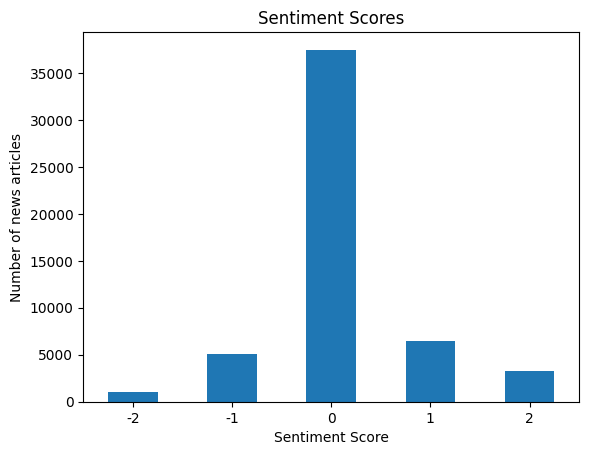

In [68]:
import matplotlib.pyplot as plt
# Draw a bar chart of the sentiment scores
temp_results_df['sentiment_score'].value_counts().sort_index().plot(kind='bar')
# rotate x axis labels to make them readable
plt.xticks(rotation=0)
plt.title('Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of news articles')
plt.show()

In [69]:
# save temp_results_df to a csv file
temp_results_df.to_csv('final_cleaned_results_v1.csv', index=False)